# Notebook to build training up from simplest case to real, eventually producing Figure S3 from Ujfalussy paper

In [1]:
import numpy as np
import tensorflow as tf
import time
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import truncexpon, poisson, norm

import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
from utils import *
from gen_inputs import *
from functs_inputs import *
from sim_hLN import *
from train_hLN import *
from init_hLN import *
from plot import *
from train_run import *

matplotlib.rcParams["savefig.dpi"] = 200
matplotlib.rcParams["legend.frameon"] = False
matplotlib.rcParams.update({'font.size': 18})

In [2]:
# 1L
Jc_1l = np.array([0])
# 1N
Jc_1n = [0]
# 2N
Jc_2n = [0, 1, 1]
# 3N
Jc_3n = [0, 1, 1, 2, 2, 3, 3]
# 4N
Jc_4n = [0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]

In [3]:
# Get some realistic inputs
X_tot = tf.convert_to_tensor(np.load('../Data/real_inputs.npy'), dtype=tf.float32)  # real inputs made earlier
X_e = X_tot[:629] # 629 excitatory inputs, in 13 ensembles
X_i = X_tot[629:] # 120 inhibitory inputs, also in 13 ensembles
# remember 1st inhibitory inputs is the somatic input - must always go to root subunit
inputs=X_tot

In [4]:
# now do multiple simulations for each case
Wce_sing, Wci_sing = np.array([np.array([0])]), np.array([np.array([])])
hln_test = hLN_Model(Jc=Jc_1l, Wce=Wce_sing, Wci=Wci_sing, sig_on=tf.constant([False]))
train_accuracies, test_accuracies, trained_params_list, target_params_list = test_recovery(model=hln_test, inputs=inputs, num_sims=10)

100%|██████████| 4000/4000 [00:26<00:00, 148.65it/s]


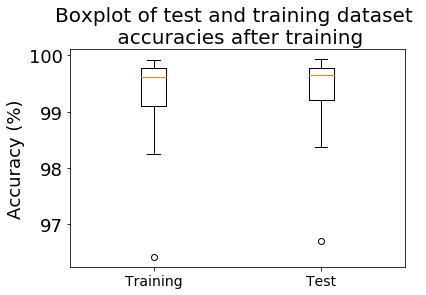

In [5]:
# box plot of recovered accuracies in hLN models
matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
ax.set_title('Boxplot of test and training dataset \n accuracies after training', fontsize=20)
ax.boxplot([train_accuracies, test_accuracies])
ax.set_xticklabels(['Training', 'Test'], fontsize=14)
ax.set_ylabel("Accuracy (%)")
# ax.set_ylim(100)
|
# plt.savefig("Figures/1l_accuracies_5attempts_10sims.png")
plt.show()

In [6]:
def plot_params_1l(trained_params, target_params, name="name", save=False):
    """create plots to compare trained parameters with target parameters for single subunit linear model.
    trained_params and target_params are lists of parameters for multiple recoveries returned by the test_recovery
    function."""

    trained_params, target_params = np.array(trained_params), np.array(target_params)

    fig, ax = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches(15, 15)

    # extract the linear parameters we want for plotting
    trained_v0s, target_v0s = trained_params[:, 0], target_params[:, 0]
    trained_Wwes, target_Wwes = np.concatenate(trained_params[:, 2]), np.concatenate(target_params[:, 2])
    trained_logTaues, target_logTaues = np.concatenate(trained_params[:, 4]), np.concatenate(target_params[:, 4])
    trained_logDelays, target_logDelays = np.concatenate(trained_params[:, 7]), np.concatenate(target_params[:, 7]) 
    
    # convert log parameters to normal values
    trained_Taues, trained_Delays = np.exp(trained_logTaues), np.exp(trained_logDelays)
    target_Taues, target_Delays = np.exp(target_logTaues), np.exp(target_logDelays)
    
    # store all linear parameters in list
    lin_target_params = [target_v0s, target_Wwes, target_Taues, target_Delays]
    lin_trained_params = [trained_v0s, trained_Wwes, trained_Taues, trained_Delays]
    
    param_names = ["v0", "Wwe", "Taue", "Delay"]
    i=0
    for row in range(2):
        for col in range(2):
            # flatten input parameter arrays for plotting
            p_trained, p_target = lin_trained_params[i], lin_target_params[i]

            if len(p_trained) > 0:
                ax[row, col].scatter(p_target, p_trained)
                x = np.linspace(min(p_trained), max(p_trained), 100)
                ax[row, col].plot(x, x, color='red', label='Perfect recovery')
                ax[row, col].set_xlabel("Truth")
                ax[row, col].set_ylabel("Recovered")
                ax[row, col].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.3f'))
                ax[row, col].xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.3f'))
                if len(p_trained) > 1:
                    var_explained = 1 - ((p_trained - p_target) ** 2).mean() / np.var(p_target)
                    ax[row, col].set_title(param_names[i] + f", ve = {100*var_explained:.2f}%")
                elif len(p_trained) == 1:
                    error = np.abs((p_trained[0] - p_target[0]) / p_target[0]) * 100
                    ax[row, col].set_title(param_names[i] + f", error ={error:.2f}%")
                ax[row, col].legend()

            i += 1

    if save:
        plt.savefig(name)

    plt.show()

    return

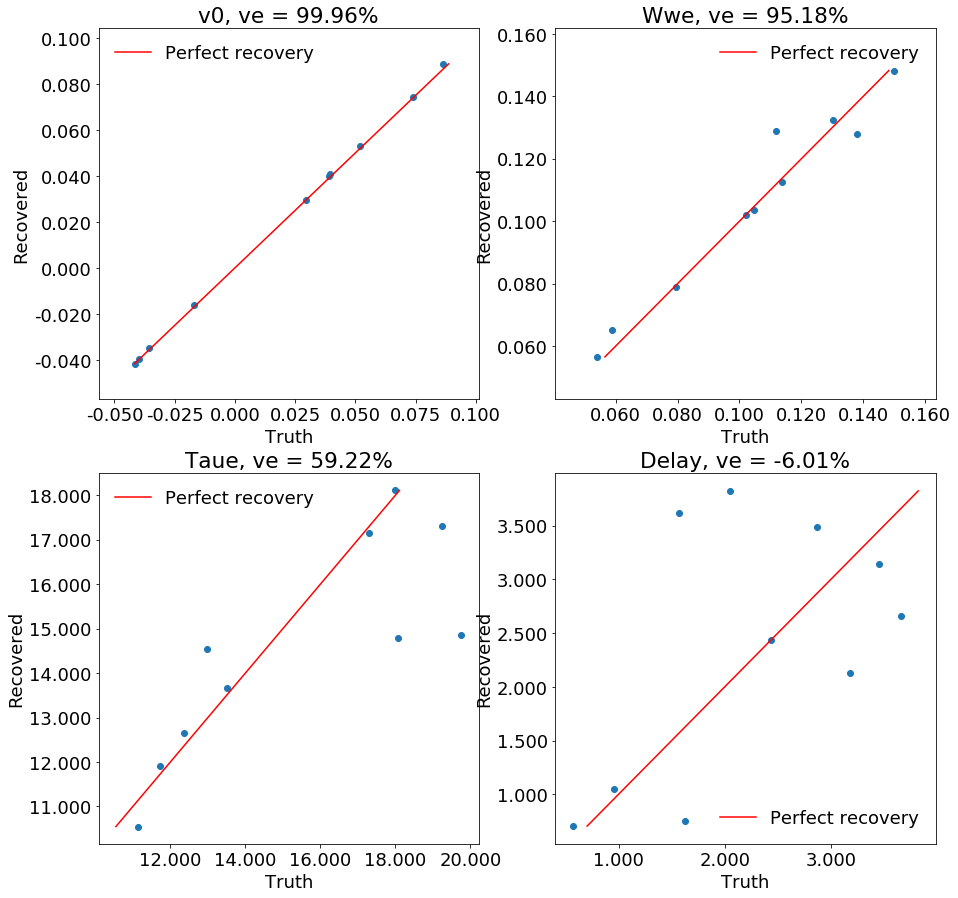

In [7]:
plot_params_1l(trained_params_list, target_params_list)

In [4]:
# test to see if 100% accuracy can be achieved with 
Wce_sing, Wci_sing = np.array([np.array([0])]), np.array([np.array([])])
hln_1sim = hLN_Model(Jc=Jc_1l, Wce=Wce_sing, Wci=Wci_sing, sig_on=tf.constant([False]))
# train_acc1, test_acc1, trained_params1, target_params1 = test_recovery(model=hln_1sim, inputs=inputs, num_sims=1, n_attempts=25, num_epochs=2000)

### Investigate how final training accuracy varies with num_attempts (number of different initial conditions training was started from) and num_epochs(number of training epochs) - we need the training loss to be 0


In [7]:
# investigate how final training accuracy varies with num_attempts (number of different initial conditions 
# training was started from) and num_epochs(number of training epochs)

# first set n_attempts = 1, change num_epochs
epochs = np.arange(100, 1100, 100)
train_accs = []
test_accs = []
for num_epochs in epochs:
    train_acc, test_acc, trained_ps1, target_ps1 = test_recovery(model=hln_1sim, inputs=inputs, num_sims=1, n_attempts=1, num_epochs=num_epochs, learning_rate=0.05)
    train_accs.append(train_acc[0].numpy())
    test_accs.append(test_acc[0].numpy())
    

100%|██████████| 1000/1000 [00:07<00:00, 141.76it/s]


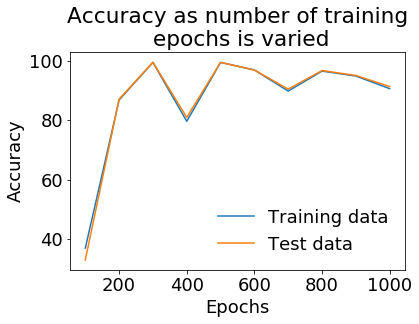

In [8]:
plt.plot(epochs, train_accs, label='Training data')
plt.plot(epochs, test_accs, label='Test data')
plt.legend()
plt.title("Accuracy as number of training\n epochs is varied")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [13]:
# now set num_epochs to minimum required for convergence (1000 seems sufficient from above cells), alter n_attempts
attempts = np.arange(1, 51, 10)
train_accs2 = []
test_accs2 = []
for n_attempts in attempts:
    train_acc, test_acc, trained_ps1, target_ps1 = test_recovery(model=hln_1sim, inputs=inputs, num_sims=1, n_attempts=n_attempts, num_epochs=200, learning_rate=0.05)
    train_accs2.append(train_acc[0].numpy())
    test_accs2.append(test_acc[0].numpy())

100%|██████████| 200/200 [00:01<00:00, 133.96it/s]


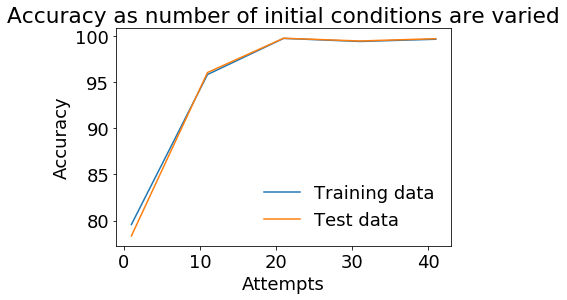

99.63339


In [15]:
plt.plot(attempts, train_accs2, label='Training data')
plt.plot(attempts, test_accs2, label='Test data')
plt.title("Accuracy as number of initial conditions are varied")
plt.xlabel("Attempts")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
print(train_accs2[-1])

In [16]:
# seems to plateau after n_attempts=20 - try this level of attempts for different numbers of training epochs
epochs = np.arange(100, 1100, 100)
train_accs3 = []
test_accs3 = []
for num_epochs in epochs:
    train_acc, test_acc, trained_ps1, target_ps1 = test_recovery(model=hln_1sim, inputs=inputs, num_sims=1, n_attempts=20, num_epochs=num_epochs, learning_rate=0.05)
    train_accs3.append(train_acc[0].numpy())
    test_accs3.append(test_acc[0].numpy())
    

100%|██████████| 800/800 [00:05<00:00, 142.40it/s]


100%|██████████| 1000/1000 [00:07<00:00, 142.80it/s]


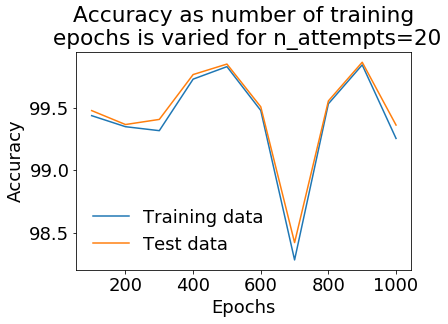

In [17]:
plt.plot(epochs, train_accs3, label='Training data')
plt.plot(epochs, test_accs3, label='Test data')
plt.legend()
plt.title("Accuracy as number of training\n epochs is varied for n_attempts=20")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()